# Analysing Feature Subsets & Classification Performance

In [127]:
import itertools

from matplotlib.pylab import plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib import pyplot, lines
from matplotlib.patches import Patch
import matplotlib

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import RFECV

from sklearn.metrics import confusion_matrix

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)




from scipy.stats import ttest_ind, f_oneway

import researchpy as rpy

from loguru import logger



import pandas as pd
import numpy as np

import seaborn as sns

import datetime 


%matplotlib inline

# Parameters

In [128]:
dataset = 'eu_us'

efs_dataset = '../data/processed/efs_{}.pkl'.format(dataset)
expanded_lockdowns_dataset = '../data/processed/expanded_lockdowns.pkl'

from_rebound_days, to_rebound_days = 28, 71

In [194]:
efs_dataset = '../data/processed/efs_eu_us_for_rebound_days_nature_mi.pkl'
expanded_lockdowns_dataset = '../data/processed/expanded_lockdowns_eu_us_for_rebound_days_nature_mi.pkl'

# Classification Analysis

## Load the EFS Dataset
The EFS dataset contains the results of the exhaustive feature search. Each row relates to a single feature subset and a given prediction horizon.

In [195]:
logger.info('Loading EFS data @ %s' % efs_dataset)

efs_df = pd.read_pickle(efs_dataset)
efs_df.shape

2020-07-31 15:07:16.519 | INFO     | __main__:<module>:1 - Loading EFS data @ ../data/processed/efs_eu_us_for_rebound_days_nature_mi.pkl


(2785195, 12)

## Load the Expanded Lockdown Dataset
This dataset contains the lockdown features and each $RR$ for a given prediction horizon.

In [196]:
logger.info('Loading lockdown data @ %s' % expanded_lockdowns_dataset)

use_expanded_lockdowns = pd.read_pickle(expanded_lockdowns_dataset).drop_duplicates()
use_expanded_lockdowns.shape

2020-07-31 15:07:26.706 | INFO     | __main__:<module>:1 - Loading lockdown data @ ../data/processed/expanded_lockdowns_eu_us_for_rebound_days_nature_mi.pkl


(6122, 67)

In [197]:
use_expanded_lockdowns['overall_start_date'].min(), use_expanded_lockdowns['overall_end_date'].max(), 

(Timestamp('2020-01-25 00:00:00'), Timestamp('2020-07-21 00:00:00'))

## Focus on a particular set of prediction horizons
We consider prediction horizons between 4 and 10 weeks after re-opening. Earlier that 4 weeks means that there has not been enough time for case levels to stablise during re-opening. After 10 weeks we start to have fewer examples of lockdowns that have opened for this period.

In [198]:
check_rebound_days = np.arange(from_rebound_days, to_rebound_days, 1)  # sorted(efs_df['rebound_days'].unique())
check_rebound_days, len(check_rebound_days)

(array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70]),
 43)

In [199]:
efs_for_rebound_days = efs_df[efs_df['rebound_days'].isin(check_rebound_days)]
efs_for_rebound_days.shape

(1408981, 12)

In [200]:
efs_for_rebound_days['rebound_days'].unique()

array([70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54,
       53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37,
       36, 35, 34, 33, 32, 31, 30, 29, 28])

In [201]:
use_features = list(set(itertools.chain.from_iterable(efs_df['feature_names'].values)))
len(use_features)

15

# Classification Error Rates

In [202]:
logger.info('Analysing EFS data from %s - %s rebound days.' % (from_rebound_days, to_rebound_days))

2020-07-31 15:07:30.480 | INFO     | __main__:<module>:1 - Analysing EFS data from 28 - 71 rebound days.


In [203]:
efs_for_rebound_days['avg_err'] = 1-efs_for_rebound_days['avg_score']

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


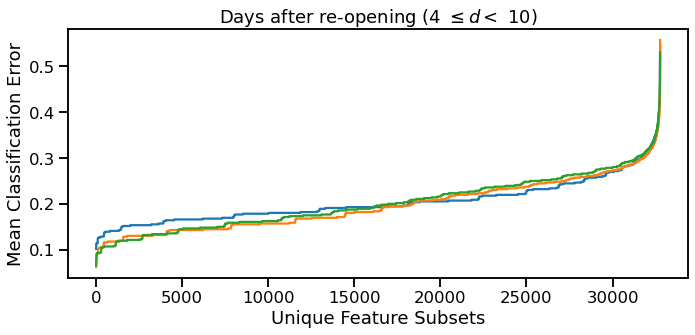

In [204]:
sns.set_context('talk')

fig,ax = plt.subplots(figsize=(10, 5))

mean_error_by_subset_4w = efs_for_rebound_days[efs_for_rebound_days['rebound_days']==28].groupby('feature_names')['avg_err'].mean().sort_values()

mean_error_by_subset_8w = efs_for_rebound_days[efs_for_rebound_days['rebound_days']==56].groupby('feature_names')['avg_err'].mean().sort_values()

mean_error_by_subset_10w = efs_for_rebound_days[efs_for_rebound_days['rebound_days']==70].groupby('feature_names')['avg_err'].mean().sort_values()



# std_error_by_subset_1m = efs_for_rebound_days[efs_for_rebound_days['rebound_days']==28].groupby('feature_names')['avg_err'].std().loc[mean_error_by_subset.index]
# upper, lower = mean_error_by_subset_1m+mean_error_by_subset_1m, mean_error_by_subset_1m-std_error_by_subset_1m
# ax.fill_between(mean_error_by_subset_1m.reset_index().index, lower, upper, alpha=.33)

ax.plot(mean_error_by_subset_4w.reset_index().index, mean_error_by_subset_4w)
ax.plot(mean_error_by_subset_8w.reset_index().index, mean_error_by_subset_8w)
ax.plot(mean_error_by_subset_10w.reset_index().index, mean_error_by_subset_10w)


ax.set_xlabel('Unique Feature Subsets')
ax.set_ylabel('Mean Classification Error')
ax.set_title('Days after re-opening (4 $\leq d <$ 10)')
fig.tight_layout()

fig.savefig('../graphs/mean_error_{}.png'.format(dataset), dpi=300, format='png', tight_layout=True)


# Choosing Feature Subsets
What are the important features when it comes to predicting success? Which feature subsets should be chosen? Is there a single feature subset that performs well across all rebound horizons?

## Feature Importance

In [205]:
def get_feature_imp(efs, top_frac=0.1):
    
    top_efs = efs.sort_values(by='avg_score', ascending=False).head(int(top_frac*len(efs)))
    bottom_efs = efs.sort_values(by='avg_score', ascending=False).tail(int(top_frac*len(efs)))

    top_efs['rank'] = top_efs['avg_score'].rank(pct=True)
    
    results = {}

    for f in use_features:

        avg_score_with_f = top_efs[top_efs['feature_names'].map(lambda fs: f in fs)]['avg_score'].mean()
        avg_score_without_f = top_efs[top_efs['feature_names'].map(lambda fs: f not in fs)]['avg_score'].mean()
        
        top_frac_with_f = len(top_efs[top_efs['feature_names'].map(lambda fs: f in fs)])/len(top_efs)
        bottom_frac_with_f = len(bottom_efs[bottom_efs['feature_names'].map(lambda fs: f in fs)])/len(bottom_efs)

        
        rank_with_f = top_efs[top_efs['feature_names'].map(lambda fs: f in fs)]['rank'].mean()

        results[f] = [avg_score_with_f, avg_score_without_f, avg_score_with_f/avg_score_without_f, top_frac_with_f, bottom_frac_with_f, top_frac_with_f-bottom_frac_with_f, rank_with_f]

    return pd.DataFrame\
        .from_dict(results, orient='index', columns=['avg_score_with', 'avg_score_without', 'avg_score_ratio', 'top_frac_with_f', 'bottom_frac_with_f', 'diff_frac_with_f', 'rank_with_f'])\
        .sort_values(by='diff_frac_with_f', ascending=False)

lockdown_min_mobility_level              0.323210
lockdown_exit_level_deaths               0.327775
lockdown_mean_mobility_level             0.328740
lockdown_days_from_peak_deaths           0.336705
lockdown_duration_days                   0.433612
lockdown_days_from_peak_cases            0.434385
lockdown_mean_value_cases_per_million    0.436685
lockdown_peak_value_deaths_per_100k      0.439475
lockdown_peak_value_cases_per_million    0.441321
lockdown_days_to_peak_deaths             0.499539
lockdown_days_to_peak_cases              0.533989
lockdown_entry_level_cases               0.534337
lockdown_mean_value_deaths_per_100k      0.542217
lockdown_entry_level_deaths              0.624194
lockdown_exit_level_cases                0.988400
dtype: float64

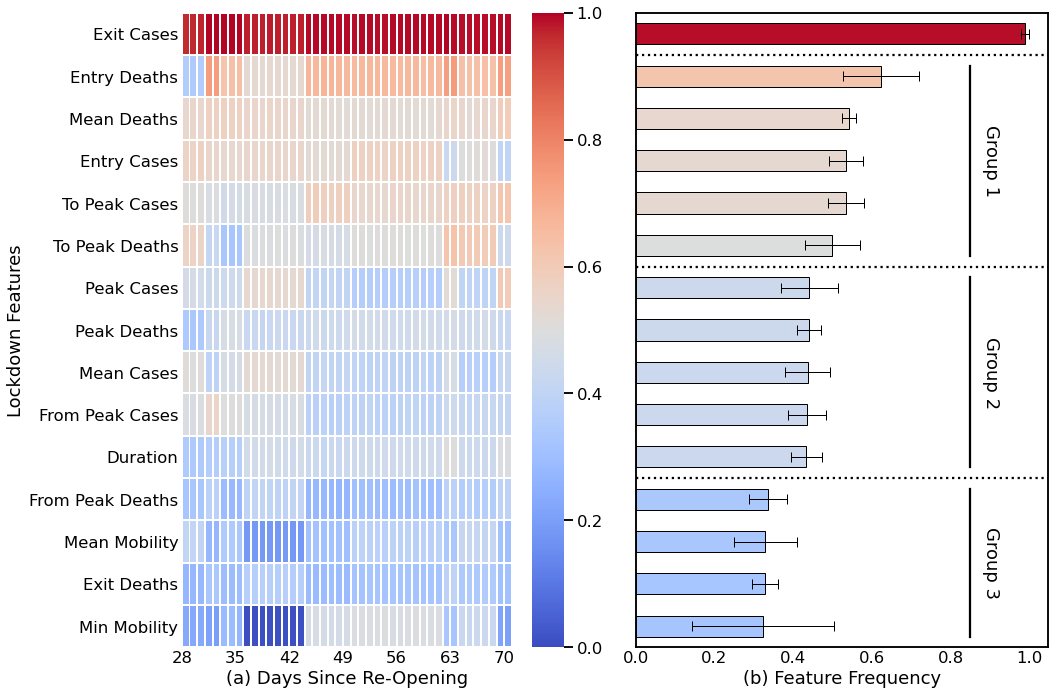

In [206]:
sns.set_context('talk')

def adjust_feature_label(label):

        return label.replace('lockdown_', '')\
            .replace('level', '')\
            .replace('value_','')\
            .replace('_per_100k','')\
            .replace('_per_million', '')\
            .replace('days', '')\
            .replace('_', ' ')\
            .replace('  ', ' ')\
            .strip().title()

def plot_feature_importances(efs_for_rebound_days, p=0.1):

    fig, (ax, bx) = plt.subplots(figsize=(15, 10), ncols=2)

    # THE HEATMAP - shows the frequency of features in the top 100*p% of feature subsets by classification accuracy
    avg_score_for_best_features_by_rebound_days = efs_for_rebound_days.groupby(efs_for_rebound_days['rebound_days']//1*1).apply(
        lambda g: get_feature_imp(g, top_frac=p)['top_frac_with_f']).unstack()

    sorted_index = avg_score_for_best_features_by_rebound_days.mean().sort_values(ascending=False).index

    use_cmap = 'coolwarm'
    sns.heatmap(avg_score_for_best_features_by_rebound_days.T.loc[sorted_index],
                ax=ax, 
                vmin=0, vmax=1,
                lw=1, linecolor='w', 
                annot = False, fmt='.2g', cmap=use_cmap, cbar=True, square=False, annot_kws=dict(fontsize=14),
               )


#     ax.set_xticklabels([int(label.get_text())//7 for label in ax.get_xticklabels()])
#     ax.set_xticks(np.arange(0, 85, 2))
    num_cols = len(avg_score_for_best_features_by_rebound_days.T.loc[sorted_index].columns)
    ax.set_xlim(0, num_cols)
    ax.set_xticks(np.arange(0, num_cols+1, 7))
    ax.set_xticklabels(np.arange(28, 71, 7))
    
    ax.set_xlabel('(a) Days Since Re-Opening')

    ylabels = [adjust_feature_label(label.get_text()) for label in ax.get_yticklabels()]
    ax.set_yticklabels(ylabels)

    ax.tick_params(axis=u'both', which=u'both',length=0)

    ax.set_ylabel('Lockdown Features')


    # THE BAR CHART - shows the average ferquency acropss the rebound days.
    mean_freqs = avg_score_for_best_features_by_rebound_days.mean().T

    std_freqs = avg_score_for_best_features_by_rebound_days.std().T

    bar_colours = [plt.get_cmap(use_cmap)(v) for v in mean_freqs.loc[sorted_index[::-1]]]

    mean_freqs.loc[sorted_index[::-1]].plot(ax=bx, kind='barh', edgecolor='k', lw=1, xerr=std_freqs.loc[sorted_index[::-1]], color=bar_colours, error_kw=dict(lw=1, capsize=5))

    bx.set_xlabel('(b) Feature Frequency')
    bx.set_yticklabels([])

    bx.tick_params(axis=u'both', which=u'both',length=0)
    
    
    def highlight_group(bx, label, y1, y2):
        
        bx.plot([0.85, 0.85], [y1, y2], c='k')
        bx.text(.88, (y1+y2)/2, label, rotation=270, va='center')

    highlight_group(bx, 'Group 1', 8.75, 13.25)
    highlight_group(bx, 'Group 2', 3.75, 8.25)
    highlight_group(bx, 'Group 3', -.25, 3.25)
    
    bx.axhline(13.5, c='k', ls=':')

    bx.axhline(8.5, c='k', ls=':')

    bx.axhline(3.5, c='k', ls=':')




    
    return fig, mean_freqs


fig, mean_freqs = plot_feature_importances(efs_for_rebound_days, p=0.1)

fig.tight_layout()

fig.savefig('../graphs/feature_importance_{}.png'.format(dataset), dpi=300, format='png', tight_layout=True)

mean_freqs.sort_values()

We can see here how the `exit cases` feature is by far the most frequent among the top 10% of feature subsets regardless of the prediction horizon (rebound weeks). The other featuresa appear significantly less frequently on on a steadily decreasing mean frequency scale with varying standard deviations

## Comparing Individual Feature Subsets
The feature importance values tell us about the frequencies with which individual features occur in the top performing feature subsets but they dont tell us about which features tend to co-occur with which other features. In make predictions in practice we need to decide on a subset of features to use and for simplicity it would be nice to use the same feature subset regardless of the prediction horizon. So, which feature subset should we use and how effective will it be?

In [207]:
min_mean_features = efs_for_rebound_days.groupby('feature_names')['avg_err'].mean().sort_values(ascending=True).index[0]
min_mean_features

('lockdown_days_to_peak_cases',
 'lockdown_exit_level_cases',
 'lockdown_mean_value_cases_per_million',
 'lockdown_entry_level_deaths')

In [208]:
min_max_features = efs_for_rebound_days.groupby('feature_names')['avg_err'].max().sort_values(ascending=True).index[0]
min_max_features

('lockdown_days_to_peak_cases',
 'lockdown_days_from_peak_cases',
 'lockdown_exit_level_cases',
 'lockdown_mean_value_cases_per_million',
 'lockdown_entry_level_deaths',
 'lockdown_mean_value_deaths_per_100k')

In [209]:
min_min_features = efs_for_rebound_days.groupby('feature_names')['avg_err'].min().sort_values(ascending=True).index[0]
min_min_features

('lockdown_duration_days',
 'lockdown_days_from_peak_cases',
 'lockdown_exit_level_cases',
 'lockdown_peak_value_cases_per_million',
 'lockdown_mean_value_cases_per_million',
 'lockdown_days_to_peak_deaths',
 'lockdown_mean_value_deaths_per_100k')

In [210]:
best_single_feature = efs_for_rebound_days[efs_for_rebound_days['n']==1].groupby('feature_names')['avg_err'].mean().sort_values(ascending=True).index[0]
best_single_feature

('lockdown_exit_level_cases',)

In [211]:
all_features = efs_for_rebound_days[efs_for_rebound_days['n']==15].groupby('feature_names')['avg_err'].mean().sort_values(ascending=True).index[0]
all_features

('lockdown_min_mobility_level',
 'lockdown_mean_mobility_level',
 'lockdown_duration_days',
 'lockdown_days_to_peak_cases',
 'lockdown_days_from_peak_cases',
 'lockdown_entry_level_cases',
 'lockdown_exit_level_cases',
 'lockdown_peak_value_cases_per_million',
 'lockdown_mean_value_cases_per_million',
 'lockdown_days_to_peak_deaths',
 'lockdown_days_from_peak_deaths',
 'lockdown_entry_level_deaths',
 'lockdown_exit_level_deaths',
 'lockdown_peak_value_deaths_per_100k',
 'lockdown_mean_value_deaths_per_100k')

In [212]:
# The optimal feature subets for each individual prediction horizon, so that we can judge how close a particulare feature subset is to optimal.
optimal_avg_error = efs_for_rebound_days.groupby('rebound_days').apply(lambda g: g.sort_values(by='avg_err', ascending=True).iloc[0]['avg_err'])

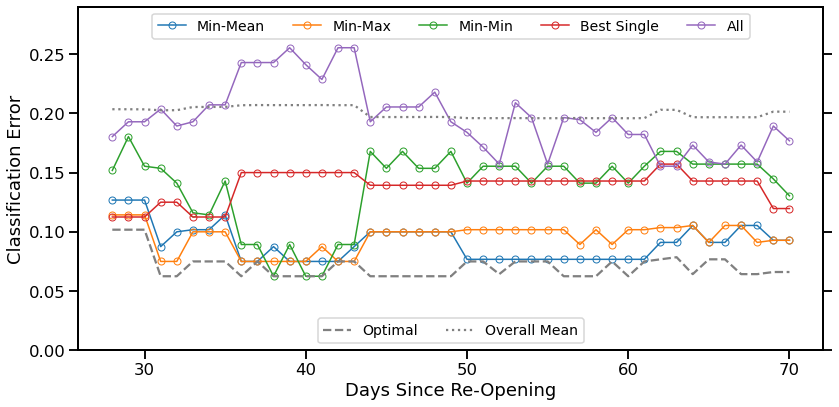

In [213]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 6))

min_mean_error = efs_for_rebound_days[efs_for_rebound_days['feature_names']==min_mean_features].set_index('rebound_days')['avg_err']
min_max_error = efs_for_rebound_days[efs_for_rebound_days['feature_names']==min_max_features].set_index('rebound_days')['avg_err']
min_min_error = efs_for_rebound_days[efs_for_rebound_days['feature_names']==min_min_features].set_index('rebound_days')['avg_err']

# The lockdown_exit_level_cases feature on its own.
best_single_error = efs_for_rebound_days[efs_for_rebound_days['feature_names']==best_single_feature].set_index('rebound_days')['avg_err']

# All of the features
all_error = efs_for_rebound_days[efs_for_rebound_days['feature_names']==all_features].set_index('rebound_days')['avg_err']

min_mean_error.plot(ax=ax, label='Min-Mean', lw=1.5, marker='o', markersize=7, markerfacecolor='none', color='tab:blue')
min_max_error.plot(ax=ax, label='Min-Max', lw=1.5, marker='o', markersize=7, markerfacecolor='none', color='tab:orange')
min_min_error.plot(ax=ax, label='Min-Min', lw=1.5, marker='o', markersize=7, markerfacecolor='none', color='tab:green')

best_single_error.plot(ax=ax, label='Best Single', lw=1.5, marker='o', markersize=7, markerfacecolor='none', color='tab:red')
all_error.plot(ax=ax, label='All', lw=1.5, marker='o', markersize=7, markerfacecolor='none', color='tab:purple')


ax2=ax.twinx()

optimal_avg_error.plot(ax=ax2, c='grey', ls='--', label='Optimal')

mean_error = efs_for_rebound_days.groupby('rebound_days')['avg_err'].mean()
mean_error.plot(ax=ax2, label='Overall Mean', c='grey', ls=':')


ax.set_ylim(0, .29)
ax2.set_ylim(0, .29)
ax2.set_yticklabels([])

ax.legend(ncol=5, loc='upper center', fontsize=14)
ax2.legend(ncol=2, loc='lower center', fontsize=14)


ax.set_xlabel('Days Since Re-Opening')
ax.set_ylabel('Classification Error')




fig.tight_layout()

fig.savefig('../graphs/err_by_weeks_{}.png'.format(dataset), dpi=300, format='png', tight_layout=True)

[0.07072259136212623,
 0.09065614617940194,
 0.09518272425249166,
 0.13820598006644516,
 0.13820598006644522,
 0.19671926910299006,
 0.2002655161019679]

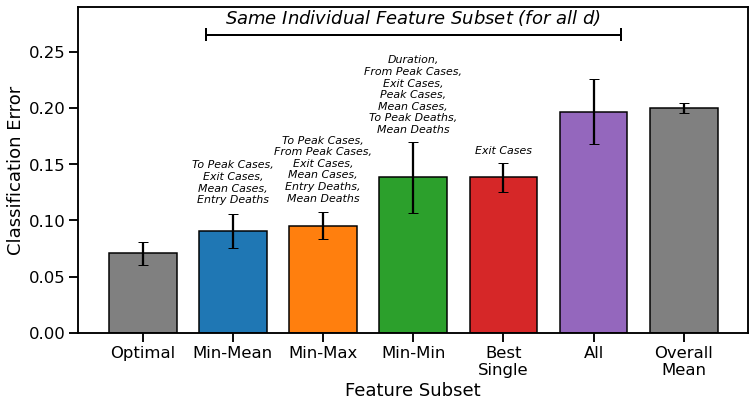

In [214]:
fig, bx = plt.subplots(figsize=(12, 6))


bx.bar(
    ['Optimal', 'Min-Mean', 'Min-Max', 'Min-Min', 'Best\nSingle', 'All', 'Overall\nMean'], 
    [optimal_avg_error.mean(), min_mean_error.mean(), min_max_error.mean(), min_min_error.mean(), best_single_error.mean(), all_error.mean(), mean_error.mean()],
    yerr=[optimal_avg_error.std(), min_mean_error.std(), min_max_error.std(), min_min_error.std(), best_single_error.std(), all_error.std(), mean_error.std()], 
    width=.75, color=['grey', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'grey'], edgecolor='k', lw=1.5, capsize=5
)

min_mean_labels = [adjust_feature_label(f) for f in min_mean_features]
bx.annotate(
    ',\n'.join(min_mean_labels), 
    xy=(1, min_mean_error.mean()+.025), rotation=0, fontsize=11, style='italic', ha='center'
)

min_max_labels = [adjust_feature_label(f) for f in min_max_features]
bx.annotate(
    ',\n'.join(min_max_labels), 
    xy=(2, min_max_error.mean()+.022), rotation=0, fontsize=11, style='italic', ha='center'
)

min_min_labels = [adjust_feature_label(f) for f in min_min_features]
bx.annotate(
    ',\n'.join(min_min_labels), 
    xy=(3, min_min_error.mean()+.04), rotation=0, fontsize=11, style='italic', ha='center'
)


best_single_label = adjust_feature_label(best_single_feature[0])
bx.annotate(
    best_single_label,
    xy=(4, best_single_error.mean()+.021), rotation=0, fontsize=11, style='italic', ha='center'
)
bx.set_ylim(0, .29)

bx.set_xlabel('Feature Subset')
bx.set_ylabel('Classification Error')

bx.plot([.7, 5.3], [.265, .265], lw=2, c='k')
bx.plot([.7, .7], [.26, .27], lw=2, c='k')
bx.plot([5.3, 5.3], [.26, .27], lw=2, c='k')
bx.text(3, .275, 'Same Individual Feature Subset (for all $d$)', ha='center', style='oblique')



fig.savefig('../graphs/mean_err_{}.png'.format(dataset), dpi=300, format='png', tight_layout=True)
[optimal_avg_error.mean(), min_mean_error.mean(), min_max_error.mean(), min_min_error.mean(), best_single_error.mean(), all_error.mean(), mean_error.mean()]

### Statistical Comparison

In [215]:
f_oneway(min_mean_error, min_max_error, min_min_error, best_single_error, all_error)

F_onewayResult(statistic=165.51593993707093, pvalue=9.603198920121696e-64)

In [216]:
# from https://pythonhealthcare.org/2018/04/13/55-statistics-multi-comparison-with-tukeys-test-and-the-holm-bonferroni-method/

df = pd.DataFrame()
df['optimal'] = optimal_avg_error
df['min_mean'] = min_mean_error
df['min_max'] = min_max_error
df['min_min'] = min_min_error
df['single_best'] = best_single_error
df['all'] = all_error


stacked_data = df.stack().reset_index()
stacked_data = stacked_data.rename(columns={'level_0': 'id',
                                            'level_1': 'treatment',
                                            0:'result'})

MultiComp = MultiComparison(stacked_data['result'],
                            stacked_data['treatment'])

# Show all pair-wise comparisons:

# Print the comparisons

print(MultiComp.tukeyhsd(alpha=.01).summary())

df.mean()

   Multiple Comparison of Means - Tukey HSD, FWER=0.01    
 group1     group2   meandiff p-adj  lower   upper  reject
----------------------------------------------------------
     all     min_max  -0.1015 0.001 -0.1165 -0.0866   True
     all    min_mean  -0.1061 0.001  -0.121 -0.0911   True
     all     min_min  -0.0585 0.001 -0.0735 -0.0436   True
     all     optimal   -0.126 0.001 -0.1409  -0.111   True
     all single_best  -0.0585 0.001 -0.0735 -0.0436   True
 min_max    min_mean  -0.0045   0.9 -0.0195  0.0104  False
 min_max     min_min    0.043 0.001  0.0281   0.058   True
 min_max     optimal  -0.0245 0.001 -0.0394 -0.0095   True
 min_max single_best    0.043 0.001  0.0281   0.058   True
min_mean     min_min   0.0475 0.001  0.0326  0.0625   True
min_mean     optimal  -0.0199 0.001 -0.0349  -0.005   True
min_mean single_best   0.0475 0.001  0.0326  0.0625   True
 min_min     optimal  -0.0675 0.001 -0.0824 -0.0525   True
 min_min single_best      0.0   0.9  -0.015   0.015  Fal

optimal        0.070723
min_mean       0.090656
min_max        0.095183
min_min        0.138206
single_best    0.138206
all            0.196719
dtype: float64

In [217]:
print(MultiComp.tukeyhsd(alpha=.01).summary().as_latex_tabular())

\begin{center}
\begin{tabular}{ccccccc}
\toprule
\textbf{group1} & \textbf{group2} & \textbf{meandiff} & \textbf{p-adj} & \textbf{lower} & \textbf{upper} & \textbf{reject}  \\
\midrule
      all       &     min\_max    &      -0.1015      &     0.001      &    -0.1165     &    -0.0866     &       True       \\
      all       &    min\_mean    &      -0.1061      &     0.001      &     -0.121     &    -0.0911     &       True       \\
      all       &     min\_min    &      -0.0585      &     0.001      &    -0.0735     &    -0.0436     &       True       \\
      all       &     optimal     &       -0.126      &     0.001      &    -0.1409     &     -0.111     &       True       \\
      all       &   single\_best  &      -0.0585      &     0.001      &    -0.0735     &    -0.0436     &       True       \\
    min\_max    &    min\_mean    &      -0.0045      &      0.9       &    -0.0195     &     0.0104     &      False       \\
    min\_max    &     min\_min    &       0.043      

## The Best Performing Subsets

In [218]:
def eval_subset(feature_subset, expanded_lockdowns, check_rebound_days):
    
    all_actuals, all_preds = [], []
    
    for rebound_days in check_rebound_days:
                        
        lockdowns_for_days = expanded_lockdowns[expanded_lockdowns['rebound_duration_days']==rebound_days]

        X = lockdowns_for_days[feature_subset]
        
        y = lockdowns_for_days['is_increasing_rebound']

        scaled_X = pd.DataFrame(preprocessing.scale(X), columns=X.columns, index=X.index)

        loo = LeaveOneOut()
        clf = GradientBoostingClassifier()

        preds = cross_val_predict(clf, scaled_X[feature_subset], y, cv=10, n_jobs=-1)
    
        all_actuals.extend(y)
        all_preds.extend(preds)
    
    cm = confusion_matrix(all_actuals, all_preds)
    
    tn, fp, fn, tp = cm.ravel()

    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)
    fnr = 1-tpr
    fpr = 1-tnr
    acc = (tp+tn)/(tp+tn+fp+fn)
    
    return acc, tpr, fpr, tnr, fnr, cm

In [219]:
# Adapted from: https://github.com/DTrimarchi10/confusion_matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None, 
                          show_rates=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    if show_rates:
        group_percentages = [
            "{0:.2%}".format(cf[0][0]/(cf[0][0]+cf[0][1])),
            "{0:.2%}".format(cf[0][1]/(cf[0][0]+cf[0][1])),
            "{0:.2%}".format(cf[1][0]/(cf[1][0]+cf[1][1])),
            "{0:.2%}".format(cf[1][1]/(cf[1][0]+cf[1][1])),
        ]
    
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.yticks(plt.yticks()[0], categories, rotation=90, va="center")
    if xyplotlabels:
        plt.ylabel('Actual', style='italic')
        plt.xlabel('Predicted' + stats_text, style='italic')
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
    plt.tick_params(axis=u'both', which=u'both',length=0)

    plt.tight_layout()
    
    return plt

## Min-Mean

In [220]:
check_rebound_days

array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70])

(0.09295946357817741,
 0.9070405364218226,
 0.927262313860252,
 0.11596091205211723,
 0.8840390879478828,
 0.07273768613974796,
 array([[1357,  178],
        [ 127, 1619]]))

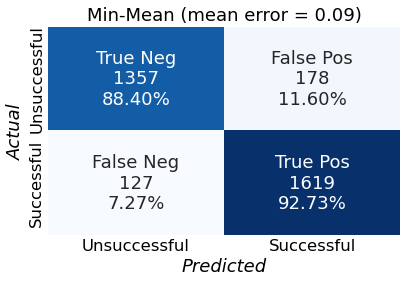

In [221]:
acc, tpr, fpr, tnr, fnr, cm = eval_subset(list(min_mean_features), use_expanded_lockdowns, check_rebound_days)

fig = make_confusion_matrix(
    cm, cbar=False, percent=False, sum_stats=False,
    group_names=['True Neg','False Pos','False Neg','True Pos'],
    categories=['Unsuccessful', 'Successful'],
)

fig.title('Min-Mean (mean error = {:.2f})'.format(1-acc))
fig.savefig('../graphs/min_mean_cm_{}.png'.format(dataset), dpi=300, format='png', tight_layout=True)

(1-acc), acc, tpr, fpr, tnr, fnr, cm

## Min-Max

(0.0975312404754648,
 0.9024687595245352,
 0.9410080183276059,
 0.1413680781758958,
 0.8586319218241042,
 0.058991981672394056,
 array([[1318,  217],
        [ 103, 1643]]))

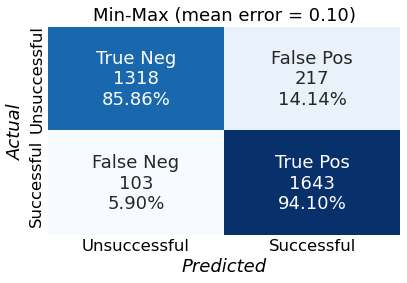

In [222]:
acc, tpr, fpr, tnr, fnr, cm = eval_subset(list(min_max_features), use_expanded_lockdowns, check_rebound_days)

fig = make_confusion_matrix(
    cm, cbar=False, percent=False, sum_stats=False,
    group_names=['True Neg','False Pos','False Neg','True Pos'],
    categories=['Unsuccessful', 'Successful'],
)

fig.title('Min-Max (mean error = {:.2f})'.format(1-acc))


fig.savefig('../graphs/min_max_cm_{}.png'.format(dataset), dpi=300, format='png', tight_layout=True)



(1-acc), acc, tpr, fpr, tnr, fnr, cm

## Min-Min

(0.14324900944833896,
 0.856750990551661,
 0.8883161512027491,
 0.17915309446254069,
 0.8208469055374593,
 0.1116838487972509,
 array([[1260,  275],
        [ 195, 1551]]))

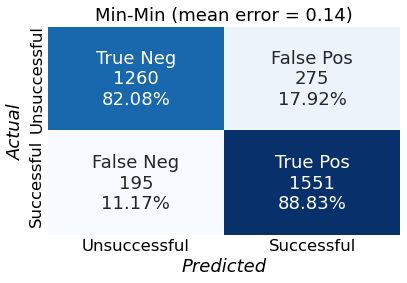

In [223]:
acc, tpr, fpr, tnr, fnr, cm = eval_subset(list(min_min_features), use_expanded_lockdowns, check_rebound_days)

fig = make_confusion_matrix(
    cm, cbar=False, percent=False, sum_stats=False,
    group_names=['True Neg','False Pos','False Neg','True Pos'],
    categories=['Unsuccessful', 'Successful'],
)

fig.title('Min-Min (mean error = {:.2f})'.format(1-acc))

fig.savefig('../graphs/min_min_cm_{}.png'.format(dataset), dpi=300, format='png', tight_layout=True)

(1-acc), acc, tpr, fpr, tnr, fnr, cm

## Best Single

(0.14172508381590976,
 0.8582749161840902,
 0.8602520045819015,
 0.14397394136807817,
 0.8560260586319218,
 0.13974799541809846,
 array([[1314,  221],
        [ 244, 1502]]))

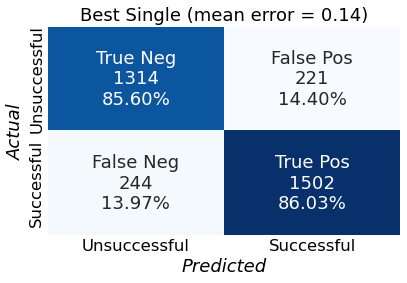

In [224]:
acc, tpr, fpr, tnr, fnr, cm = eval_subset([best_single_feature[0]], use_expanded_lockdowns, check_rebound_days)

fig = make_confusion_matrix(
    cm, cbar=False, percent=False, sum_stats=False,
    group_names=['True Neg','False Pos','False Neg','True Pos'],
    categories=['Unsuccessful', 'Successful'],
)

fig.title('Best Single (mean error = {:.2f})'.format(1-acc))

fig.savefig('../graphs/best_single_cm_{}.png'.format(dataset), dpi=300, format='png', tight_layout=True)



(1-acc), acc, tpr, fpr, tnr, fnr, cm

## All

(0.19871990246875948,
 0.8012800975312405,
 0.8459335624284078,
 0.24951140065146582,
 0.7504885993485342,
 0.15406643757159222,
 array([[1152,  383],
        [ 269, 1477]]))

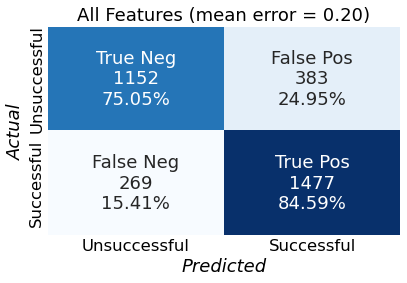

In [225]:
acc, tpr, fpr, tnr, fnr, cm = eval_subset(list(all_features), use_expanded_lockdowns, check_rebound_days)

fig = make_confusion_matrix(
    cm, cbar=False, percent=False, sum_stats=False,
    group_names=['True Neg','False Pos','False Neg','True Pos'],
    categories=['Unsuccessful', 'Successful'],
)

fig.title('All Features (mean error = {:.2f})'.format(1-acc))

fig.savefig('../graphs/all_cm_{}.png'.format(dataset), dpi=300, format='png', tight_layout=True)



(1-acc), acc, tpr, fpr, tnr, fnr, cm